In [1]:
from bs4 import BeautifulSoup
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import pickle as pkl
import sklearn
import spacy
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm_notebook
import os

In [6]:
pos_train_data = []
neg_train_data = []
pos_test_data = []
neg_test_data = []
pos_train_path = './data/train/pos'
neg_train_path = './data/train/neg'
pos_test_path = './data/test/pos'
neg_test_path = './data/test/neg'

pos_train_files = [pos_train_path + '/' + f for f in os.listdir(pos_train_path) if  + os.path.isfile(pos_train_path + '/' + f)]
neg_train_files = [neg_train_path + '/' + f for f in os.listdir(neg_train_path) if  + os.path.isfile(neg_train_path + '/' + f)]

pos_test_files = [pos_test_path + '/' + f for f in os.listdir(pos_test_path) if  + os.path.isfile(pos_test_path + '/' + f)]
neg_test_files = [neg_test_path + '/' + f for f in os.listdir(neg_test_path) if  + os.path.isfile(neg_test_path + '/' + f)]

for f in pos_train_files:
    with open(f, "r") as posfile:
        pos_train_data.append(posfile.read())
for f in neg_train_files:
    with open(f, "r") as negfile:
        neg_train_data.append(negfile.read())
for f in pos_test_files:
    with open(f, "r") as posfile:
        pos_test_data.append(posfile.read())
for f in neg_test_files:
    with open(f, "r") as negfile:
        neg_test_data.append(negfile.read())



In [7]:
pos_train_df = pd.DataFrame(pos_train_data, columns=['text'])
neg_train_df = pd.DataFrame(neg_train_data, columns=['text'])
pos_test_df = pd.DataFrame(pos_test_data, columns=['text'])
neg_test_df = pd.DataFrame(neg_test_data, columns=['text'])
pos_train_df['sentiment'] = 1
neg_train_df['sentiment'] = 0
pos_test_df['sentiment'] = 1
neg_test_df['sentiment'] = 0
raw_train_reviews = sklearn.utils.shuffle(pos_train_df.append(neg_train_df)).reset_index(drop=True)
raw_test_reviews = sklearn.utils.shuffle(pos_test_df.append(neg_test_df)).reset_index(drop=True)

In [9]:
print(raw_train_reviews.head(10))
print(raw_test_reviews['text'][0])

                                                text  sentiment
0  This is one of the worst movies I've seen in a...          0
1  Film starts in 1840 Japan in which a man slash...          0
2  This work is less about Steve Martin's charact...          1
3  His first movie after longtime friend John Bel...          0
4  As far as I can tell you, in spite of earlier ...          0
5  "Spin it!"<br /><br />The 90s opened up with a...          1
6  La Teta y la Luna is a symbolic spain film. Ev...          1
7  Yes its an art... to successfully make a slow ...          1
8  I thought this movie was stunning, with comple...          1
9  Elephant Walk (1954) Starring an early Peter F...          1
Cult film-maker Corbucci's rarest of his thirteen Spaghetti Westerns (of which I'm only left with WHAT AM I DOING IN THE MIDDLE OF THE REVOLUTION [1972] to catch) is one I only became aware of fairly recently via Marco Giusti's "Stracult" guide; it's an atypically bleak genre gem in the style of

In [10]:
train_reviews_data = raw_train_reviews['text']
train_reviews_target = raw_train_reviews['sentiment']
test_reviews_data = raw_test_reviews['text']
test_reviews_target = raw_test_reviews['sentiment']
# Strip HTML tags and punctuation, and makes text lowercase
pre_train_reviews_data = train_reviews_data.apply(lambda review: BeautifulSoup(review).get_text(" ").lower().translate(str.maketrans('','',string.punctuation)))
pre_test_reviews_data = test_reviews_data.apply(lambda review: BeautifulSoup(review).get_text(" ").lower().translate(str.maketrans('','',string.punctuation)))


train_split = int(len(train_reviews_data)*.8)
raw_X_train = train_reviews_data[:train_split].reset_index(drop=True)
raw_X_val = train_reviews_data[train_split:].reset_index(drop=True)
pre_X_train = pre_train_reviews_data[:train_split].reset_index(drop=True)
pre_X_val = pre_train_reviews_data[train_split:].reset_index(drop=True)
y_train = train_reviews_target[:train_split].reset_index(drop=True)
y_val = train_reviews_target[train_split:].reset_index(drop=True)

/home/darrengeng/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/darrengeng/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [13]:
print(raw_X_train[0])
print('---------------------------------------------------------------------------------')
print(pre_X_train[0])
print('---------------------------------------------------------------------------------')
print(raw_X_train.head())
print(len(raw_X_train))
print(len(raw_X_val))

This is one of the worst movies I've seen in a long time. Not just the story, but the acting is shockingly bad. The dialog sounds like someone reading the news.<br /><br />This is rated as comedy/drama/romance, it's not of those things ! It's a little action, that's it. There's really NO comedy and drama at all.<br /><br />If you went to the cinema to see this I feel sorry for you. I would not recommend it at all. Pretty much anything else that you choose to look at will be better. This is pretty much a action/crime movie. The actions scenes sucked, and crime story part of it was very predictable.<br /><br />If you are not really interested in a good story, or good acting. And you simply want to look at a 'foreign' film for the appeal of being foreign. Then this might be for you.
---------------------------------------------------------------------------------
this is one of the worst movies ive seen in a long time not just the story but the acting is shockingly bad the dialog sounds l

In [14]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
def create_ngrams(n, reviews):
    token_dataset = []
    all_tokens = []
    
    for review in tqdm_notebook(reviews):
        tokens = []
        for i in range(1, n+1):
            for ngram in nltk.ngrams(nltk.word_tokenize(review), i):
                tokens.append(ngram)
                all_tokens.append(ngram)
        token_dataset.append(tokens)

    return token_dataset, all_tokens

print ("Tokenizing raw val data")
raw_val_tokens_1gram, _ = create_ngrams(1, raw_X_val)
raw_val_tokens_2gram, _ = create_ngrams(2, raw_X_val)
raw_val_tokens_3gram, _ = create_ngrams(3, raw_X_val)
raw_val_tokens_4gram, _ = create_ngrams(4, raw_X_val)

print ("Tokenizing raw test data")
raw_test_tokens_1gram, _ = create_ngrams(1, test_reviews_data)
raw_test_tokens_2gram, _ = create_ngrams(2, test_reviews_data)
raw_test_tokens_3gram, _ = create_ngrams(3, test_reviews_data)
raw_test_tokens_4gram, _ = create_ngrams(4, test_reviews_data)

print ("Tokenizing raw train data")
raw_train_tokens_1gram, raw_all_train_tokens_1gram = create_ngrams(1, raw_X_train)
raw_train_tokens_2gram, raw_all_train_tokens_2gram = create_ngrams(2, raw_X_train)
raw_train_tokens_3gram, raw_all_train_tokens_3gram = create_ngrams(3, raw_X_train)
raw_train_tokens_4gram, raw_all_train_tokens_4gram = create_ngrams(4, raw_X_train)


In [24]:
print ("Tokenizing preprocessed test data")
pre_test_tokens_1gram, _ = create_ngrams(1, pre_test_reviews_data)
pre_test_tokens_2gram, _ = create_ngrams(2, pre_test_reviews_data)
pre_test_tokens_3gram, _ = create_ngrams(3, pre_test_reviews_data)
pre_test_tokens_4gram, _ = create_ngrams(4, pre_test_reviews_data)
print ("Tokenizing preprocessed val data")
pre_val_tokens_1gram, _ = create_ngrams(1, pre_X_val)
pre_val_tokens_2gram, _ = create_ngrams(2, pre_X_val)
pre_val_tokens_3gram, _ = create_ngrams(3, pre_X_val)
pre_val_tokens_4gram, _ = create_ngrams(4, pre_X_val)
print ("Tokenizing preprocessed train data")
pre_train_tokens_1gram, pre_all_train_tokens_1gram = create_ngrams(1, pre_X_train)
pre_train_tokens_2gram, pre_all_train_tokens_2gram = create_ngrams(2, pre_X_train)
pre_train_tokens_3gram, pre_all_train_tokens_3gram = create_ngrams(3, pre_X_train)
pre_train_tokens_4gram, pre_all_train_tokens_4gram = create_ngrams(4, pre_X_train)

Tokenizing preprocessed test data




Tokenizing preprocessed val data




Tokenizing preprocessed train data






In [18]:
from collections import Counter
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [33]:
MAX_SENTENCE_LENGTH = 1000

class MoviesReviewsDataset(Dataset):    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of review tokens 
        @param target_list: list of review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def reviews_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [20]:
class BagOfNGrams(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfNGrams, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [26]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [52]:
def create_run_model(train_tokens, y_train, val_tokens, y_val, test_tokens, y_test, all_tokens, 
                     max_vocab_size, batch_size, emb_dim, optimizer, learning_rate, annealing):
    print('Building indices/vocab...')
    token2id, id2token = build_vocab(all_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_tokens, token2id)
    val_data_indices = token2index_dataset(val_tokens, token2id)
    test_data_indices = token2index_dataset(test_tokens, token2id)
    print('Building datasets/dataloaders...')
    train_dataset = MoviesReviewsDataset(train_data_indices, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=reviews_collate_func,
                                               shuffle=True)
    val_dataset = MoviesReviewsDataset(val_data_indices, y_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=reviews_collate_func,
                                               shuffle=True)
    test_dataset = MoviesReviewsDataset(test_data_indices, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=reviews_collate_func,
                                               shuffle=True)
    print('Building model...')
    model = BagOfNGrams(len(id2token), emb_dim)
    num_epochs = 10 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss() 
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    losses = {}
    training_accs = {}
    val_accs = {}
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            if i > 0 and i % 100 == 0:
                val_acc = test_model(val_loader, model)
                training_acc = test_model(train_loader, model)
                losses[i + epoch*len(train_loader)] = loss
                training_accs[i + epoch*len(train_loader)] = training_acc
                val_accs[i + epoch*len(train_loader)] = val_acc
        val_acc = test_model(val_loader, model)
        print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                   epoch+1, num_epochs, i+1, len(train_loader), val_acc))
        if (annealing is True) and (epoch % 2 == 0):
            learning_rate = learning_rate * .5
            if optimizer == 'adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            elif optimizer == 'sgd':
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    test_acc = test_model(test_loader, model)
    print('Testing acc: {}'.format(test_acc))
    return losses, training_accs, val_accs, model

In [75]:
print('------------------------------------------------------------------')
print('unprocessed text, 1gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_1, training_accs_1, val_accs_1, _ = create_run_model(raw_train_tokens_1gram, y_train, raw_val_tokens_1gram, y_val, raw_test_tokens_1gram, test_reviews_target, raw_all_train_tokens_1gram, 
                                                   10000, 32, 100, 'adam', 0.01)
print('------------------------------------------------------------------')
print('unprocessed text, 2gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_2, training_accs_2, val_accs_2, _ = create_run_model(raw_train_tokens_2gram, y_train, raw_val_tokens_2gram, y_val, raw_test_tokens_2gram, test_reviews_target, raw_all_train_tokens_2gram, 
                                                   10000, 32, 100, 'adam', 0.01)
print('------------------------------------------------------------------')
print('unprocessed text, 3gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_3, training_accs_3, val_accs_3, _ = create_run_model(raw_train_tokens_3gram, y_train, raw_val_tokens_3gram, y_val, raw_test_tokens_3gram, test_reviews_target, all_train_tokens_3gram, 
                                                    10000, 32, 100, 'adam', 0.01)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_4, training_accs_4, val_accs_4, _ = create_run_model(raw_train_tokens_4gram, y_train, raw_val_tokens_4gram, y_val, raw_test_tokens_4gram, test_reviews_target, all_train_tokens_4gram, 
                                                    10000, 32, 100, 'adam', 0.01)

------------------------------------------------------------------
unprocessed text, 1gram, 10000 vocab, 100embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [625/625], Validation Acc: 85.46
Epoch: [2/10], Step: [625/625], Validation Acc: 87.12
Epoch: [3/10], Step: [625/625], Validation Acc: 86.68
Epoch: [4/10], Step: [625/625], Validation Acc: 85.92
Epoch: [5/10], Step: [625/625], Validation Acc: 84.92
Epoch: [6/10], Step: [625/625], Validation Acc: 84.22
Epoch: [7/10], Step: [625/625], Validation Acc: 83.42
Epoch: [8/10], Step: [625/625], Validation Acc: 83.34
Epoch: [9/10], Step: [625/625], Validation Acc: 83.62
Epoch: [10/10], Step: [625/625], Validation Acc: 83.46
------------------------------------------------------------------
unprocessed text, 2gram, 10000 vocab, 100embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [625/625], Validat

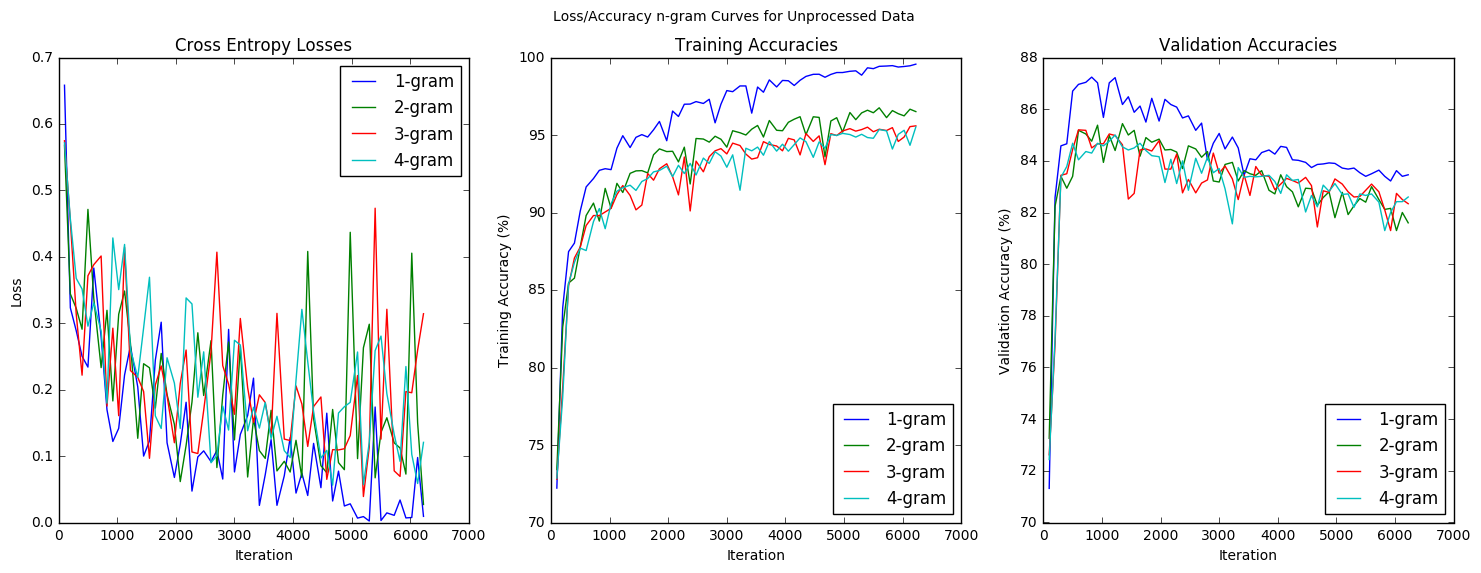

In [92]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(iters_1, losses_1, label="1-gram")
axs[0].plot(iters_2, losses_2, label="2-gram")
axs[0].plot(iters_3, losses_3, label="3-gram")
axs[0].plot(iters_4, losses_4, label="4-gram")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(training_accs_1.items())), label="1-gram")
axs[1].plot(*zip(*sorted(training_accs_2.items())), label="2-gram")
axs[1].plot(*zip(*sorted(training_accs_3.items())), label="3-gram")
axs[1].plot(*zip(*sorted(training_accs_4.items())), label="4-gram")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(val_accs_1.items())), label="1-gram")
axs[2].plot(*zip(*sorted(val_accs_2.items())), label="2-gram")
axs[2].plot(*zip(*sorted(val_accs_3.items())), label="3-gram")
axs[2].plot(*zip(*sorted(val_accs_4.items())), label="4-gram")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy n-gram Curves for Unprocessed Data')
plt.show()

In [34]:
print('------------------------------------------------------------------')
print('preprocessed text, 1gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_5, training_accs_5, val_accs_5, _ = create_run_model(pre_train_tokens_1gram, y_train, pre_val_tokens_1gram, y_val, pre_test_tokens_1gram, test_reviews_target, pre_all_train_tokens_1gram, 
                                                   10000, 32, 100, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('preprocessed text, 2gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_6, training_accs_6, val_accs_6, _ = create_run_model(pre_train_tokens_2gram, y_train, pre_val_tokens_2gram, y_val, pre_test_tokens_2gram, test_reviews_target, pre_all_train_tokens_2gram, 
                                                   10000, 32, 100, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('preprocessed text, 3gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_7, training_accs_7, val_accs_7, _ = create_run_model(pre_train_tokens_3gram, y_train, pre_val_tokens_3gram, y_val, pre_test_tokens_3gram, test_reviews_target, pre_all_train_tokens_3gram, 
                                                    10000, 32, 100, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('preprocessed text, 4gram, 10000 vocab, 100embed_dim, adam, 0.01 lr')
losses_8, training_accs_8, val_accs_8, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    10000, 32, 100, 'adam', 0.01, False)

------------------------------------------------------------------
preprocessed text, 1gram, 10000 vocab, 100embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [625/625], Validation Acc: 89.18
Epoch: [2/10], Step: [625/625], Validation Acc: 88.48
Epoch: [3/10], Step: [625/625], Validation Acc: 88.2
Epoch: [4/10], Step: [625/625], Validation Acc: 87.92
Epoch: [5/10], Step: [625/625], Validation Acc: 87.02
Epoch: [6/10], Step: [625/625], Validation Acc: 86.5
Epoch: [7/10], Step: [625/625], Validation Acc: 86.92
Epoch: [8/10], Step: [625/625], Validation Acc: 86.88
Epoch: [9/10], Step: [625/625], Validation Acc: 86.94
Epoch: [10/10], Step: [625/625], Validation Acc: 85.62
Testing rate: 83.276
------------------------------------------------------------------
preprocessed text, 2gram, 10000 vocab, 100embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Ste

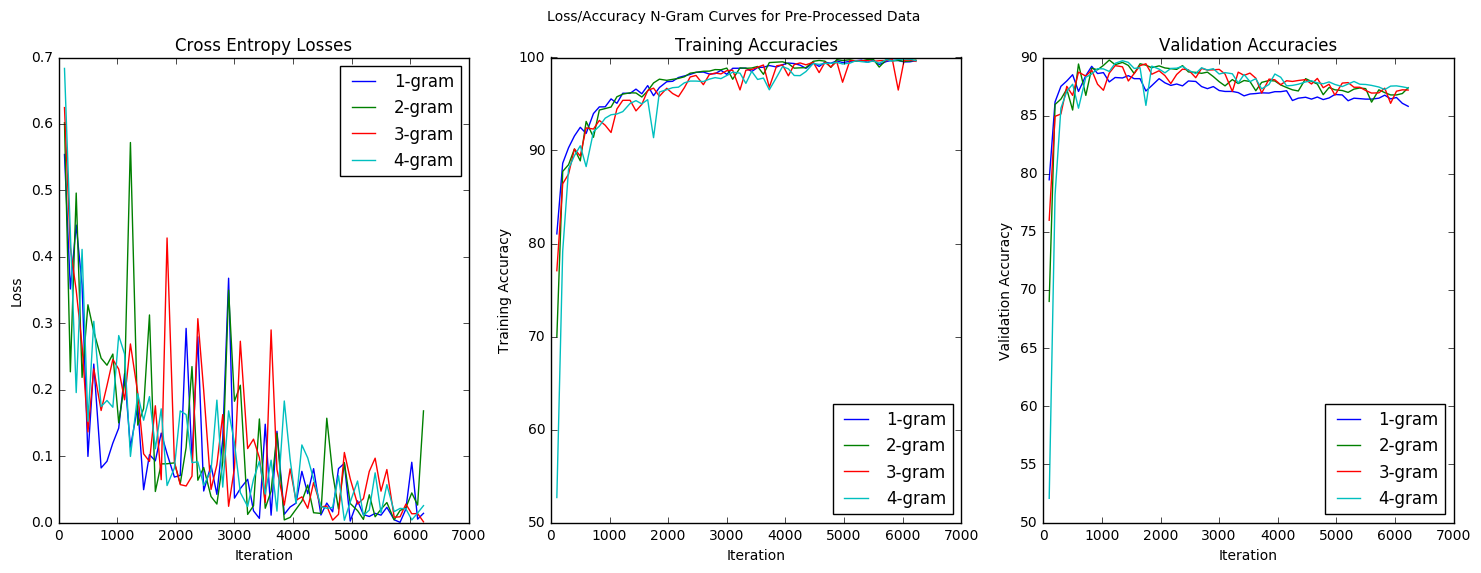

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(losses_5.items())), label="1-gram")
axs[0].plot(*zip(*sorted(losses_6.items())), label="2-gram")
axs[0].plot(*zip(*sorted(losses_7.items())), label="3-gram")
axs[0].plot(*zip(*sorted(losses_8.items())), label="4-gram")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(training_accs_5.items())), label="1-gram")
axs[1].plot(*zip(*sorted(training_accs_6.items())), label="2-gram")
axs[1].plot(*zip(*sorted(training_accs_7.items())), label="3-gram")
axs[1].plot(*zip(*sorted(training_accs_8.items())), label="4-gram")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(val_accs_5.items())), label="1-gram")
axs[2].plot(*zip(*sorted(val_accs_6.items())), label="2-gram")
axs[2].plot(*zip(*sorted(val_accs_7.items())), label="3-gram")
axs[2].plot(*zip(*sorted(val_accs_8.items())), label="4-gram")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy N-Gram Curves for Pre-Processed Data')
plt.show()

In [38]:
print('------------------------------------------------------------------')
print('unprocessed text, 2gram, 20000 vocab, 100embed_dim, adam, 0.01 lr')
losses_9, training_accs_9, val_accs_9, _ = create_run_model(pre_train_tokens_2gram, y_train, pre_val_tokens_2gram, y_val, pre_test_tokens_2gram, test_reviews_target, pre_all_train_tokens_2gram, 
                                                    20000, 32, 100, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('unprocessed text, 2gram, 30000 vocab, 100embed_dim, adam, 0.01 lr')
losses_10, training_accs_10, val_accs_10, _ = create_run_model(pre_train_tokens_2gram, y_train, pre_val_tokens_2gram, y_val, pre_test_tokens_2gram, test_reviews_target, pre_all_train_tokens_2gram, 
                                                    30000, 32, 100, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 20000 vocab, 100embed_dim, adam, 0.01 lr')
losses_11, training_accs_11, val_accs_11, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    20000, 32, 100, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 100embed_dim, adam, 0.01 lr')
losses_12, training_accs_12, val_accs_12, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 100, 'adam', 0.01, False)

------------------------------------------------------------------
unprocessed text, 2gram, 20000 vocab, 100embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [625/625], Validation Acc: 90.16
Epoch: [2/10], Step: [625/625], Validation Acc: 89.92
Epoch: [3/10], Step: [625/625], Validation Acc: 89.68
Epoch: [4/10], Step: [625/625], Validation Acc: 89.16
Epoch: [5/10], Step: [625/625], Validation Acc: 89.3
Epoch: [6/10], Step: [625/625], Validation Acc: 89.42
Epoch: [7/10], Step: [625/625], Validation Acc: 89.3
Epoch: [8/10], Step: [625/625], Validation Acc: 89.3
Epoch: [9/10], Step: [625/625], Validation Acc: 89.24
Epoch: [10/10], Step: [625/625], Validation Acc: 89.38
Testing rate: 87.484
------------------------------------------------------------------
unprocessed text, 2gram, 30000 vocab, 100embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: 

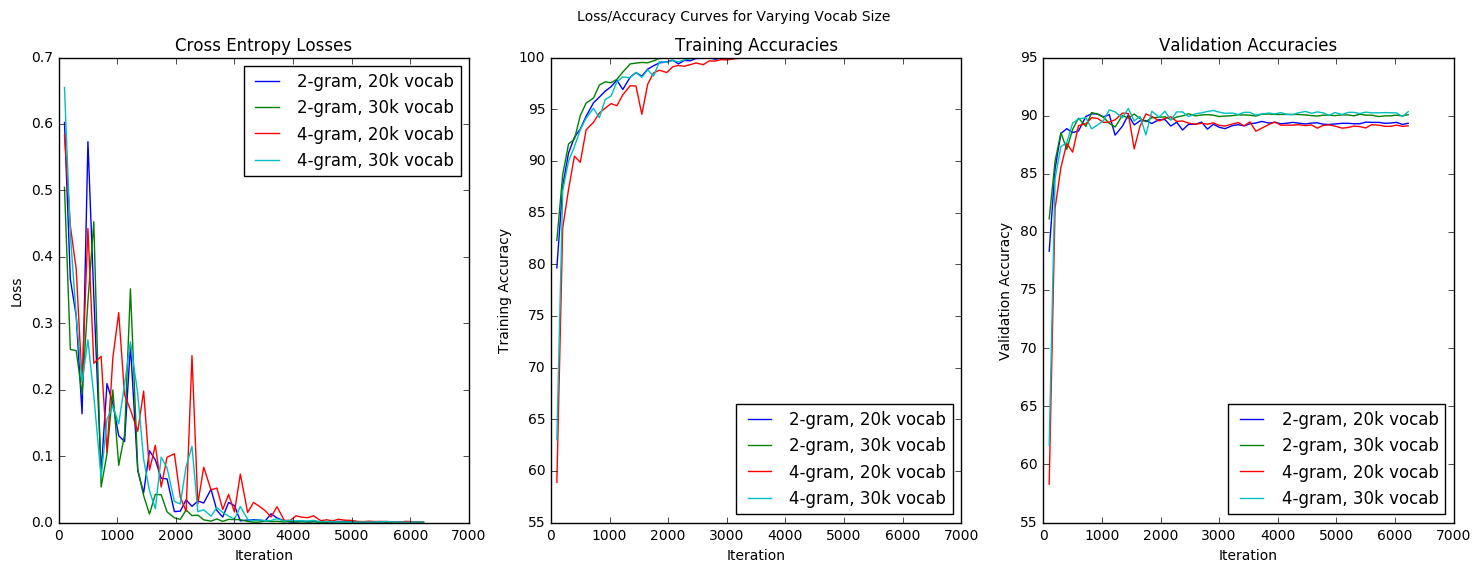

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(losses_9.items())), label="2-gram, 20k vocab")
axs[0].plot(*zip(*sorted(losses_10.items())), label="2-gram, 30k vocab")
axs[0].plot(*zip(*sorted(losses_11.items())), label="4-gram, 20k vocab")
axs[0].plot(*zip(*sorted(losses_12.items())), label="4-gram, 30k vocab")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(training_accs_9.items())), label="2-gram, 20k vocab")
axs[1].plot(*zip(*sorted(training_accs_10.items())), label="2-gram, 30k vocab")
axs[1].plot(*zip(*sorted(training_accs_11.items())), label="4-gram, 20k vocab")
axs[1].plot(*zip(*sorted(training_accs_12.items())), label="4-gram, 30k vocab")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(val_accs_9.items())), label="2-gram, 20k vocab")
axs[2].plot(*zip(*sorted(val_accs_10.items())), label="2-gram, 30k vocab")
axs[2].plot(*zip(*sorted(val_accs_11.items())), label="4-gram, 20k vocab")
axs[2].plot(*zip(*sorted(val_accs_12.items())), label="4-gram, 30k vocab")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy Curves for Varying Vocab Size')
plt.show()

In [42]:
print('------------------------------------------------------------------')
print('unprocessed text, 2gram, 30000 vocab, 50embed_dim, adam, 0.01 lr')
losses_13, training_accs_13, val_accs_13, _ = create_run_model(pre_train_tokens_2gram, y_train, pre_val_tokens_2gram, y_val, pre_test_tokens_2gram, test_reviews_target, pre_all_train_tokens_2gram, 
                                                    30000, 32, 50, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('unprocessed text, 2gram, 30000 vocab, 200embed_dim, adam, 0.01 lr')
losses_14, training_accs_14, val_accs_14, _ = create_run_model(pre_train_tokens_2gram, y_train, pre_val_tokens_2gram, y_val, pre_test_tokens_2gram, test_reviews_target, pre_all_train_tokens_2gram, 
                                                    30000, 32, 200, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 50embed_dim, adam, 0.01 lr')
losses_15, training_accs_15, val_accs_15, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 50, 'adam', 0.01, False)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 200embed_dim, adam, 0.01 lr')
losses_16, training_accs_16, val_accs_16, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 200, 'adam', 0.01, False)

------------------------------------------------------------------
unprocessed text, 2gram, 30000 vocab, 50embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [625/625], Validation Acc: 89.48
Epoch: [2/10], Step: [625/625], Validation Acc: 89.26
Epoch: [3/10], Step: [625/625], Validation Acc: 90.04
Epoch: [4/10], Step: [625/625], Validation Acc: 90.14
Epoch: [5/10], Step: [625/625], Validation Acc: 90.08
Epoch: [6/10], Step: [625/625], Validation Acc: 89.9
Epoch: [7/10], Step: [625/625], Validation Acc: 89.92
Epoch: [8/10], Step: [625/625], Validation Acc: 89.8
Epoch: [9/10], Step: [625/625], Validation Acc: 89.84
Epoch: [10/10], Step: [625/625], Validation Acc: 89.82
Testing acc: 88.232
------------------------------------------------------------------
unprocessed text, 2gram, 30000 vocab, 200embed_dim, adam, 0.01 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [

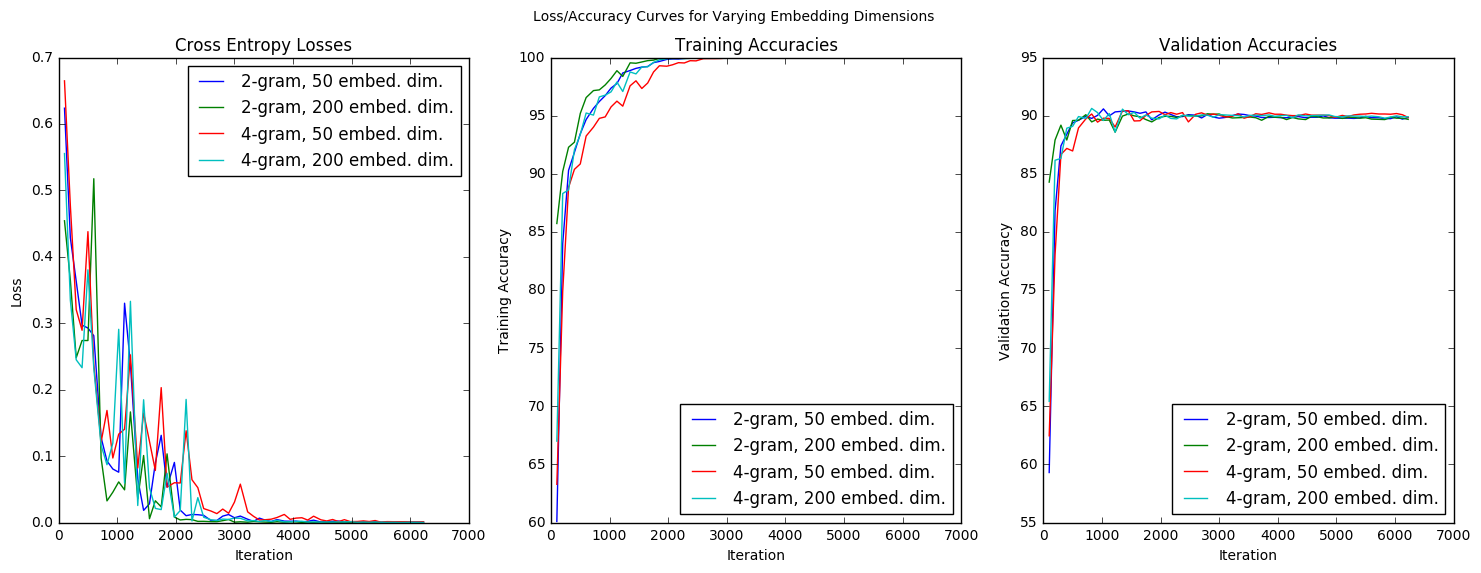

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(losses_13.items())), label="2-gram, 50 embed. dim.")
axs[0].plot(*zip(*sorted(losses_14.items())), label="2-gram, 200 embed. dim.")
axs[0].plot(*zip(*sorted(losses_15.items())), label="4-gram, 50 embed. dim.")
axs[0].plot(*zip(*sorted(losses_16.items())), label="4-gram, 200 embed. dim.")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(training_accs_13.items())), label="2-gram, 50 embed. dim.")
axs[1].plot(*zip(*sorted(training_accs_14.items())), label="2-gram, 200 embed. dim.")
axs[1].plot(*zip(*sorted(training_accs_15.items())), label="4-gram, 50 embed. dim.")
axs[1].plot(*zip(*sorted(training_accs_16.items())), label="4-gram, 200 embed. dim.")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(val_accs_13.items())), label="2-gram, 50 embed. dim.")
axs[2].plot(*zip(*sorted(val_accs_14.items())), label="2-gram, 200 embed. dim.")
axs[2].plot(*zip(*sorted(val_accs_15.items())), label="4-gram, 50 embed. dim.")
axs[2].plot(*zip(*sorted(val_accs_16.items())), label="4-gram, 200 embed. dim.")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy Curves for Varying Embedding Dimensions')
plt.show()

In [47]:
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 100 embed_dim, adam, 0.001 lr')
losses_17, training_accs_17, val_accs_17, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 100, 'adam', 0.001, False)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 100 embed_dim, sgd, 0.01 lr (Annealing)')
losses_18, training_accs_18, val_accs_18, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 100, 'adam', 0.01, True)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 100 embed_dim, SGD, 0.001 lr')
losses_19, training_accs_19, val_accs_19, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 100, 'sgd', 0.01, False)
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 100 embed_dim, SGD, 0.01 lr (Annealing)')
losses_20, training_accs_20, val_accs_20, _ = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 100, 'sgd', 0.001, True)

------------------------------------------------------------------
unprocessed text, 4gram, 30000 vocab, 100 embed_dim, adam, 0.001 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [625/625], Validation Acc: 76.22
Epoch: [2/10], Step: [625/625], Validation Acc: 82.76
Epoch: [3/10], Step: [625/625], Validation Acc: 86.04
Epoch: [4/10], Step: [625/625], Validation Acc: 87.74
Epoch: [5/10], Step: [625/625], Validation Acc: 87.4
Epoch: [6/10], Step: [625/625], Validation Acc: 88.74
Epoch: [7/10], Step: [625/625], Validation Acc: 89.4
Epoch: [8/10], Step: [625/625], Validation Acc: 89.58
Epoch: [9/10], Step: [625/625], Validation Acc: 90.04
Epoch: [10/10], Step: [625/625], Validation Acc: 90.44
Testing acc: 89.68
------------------------------------------------------------------
unprocessed text, 4gram, 30000 vocab, 100 embed_dim, sgd, 0.01 lr (Annealing)
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [

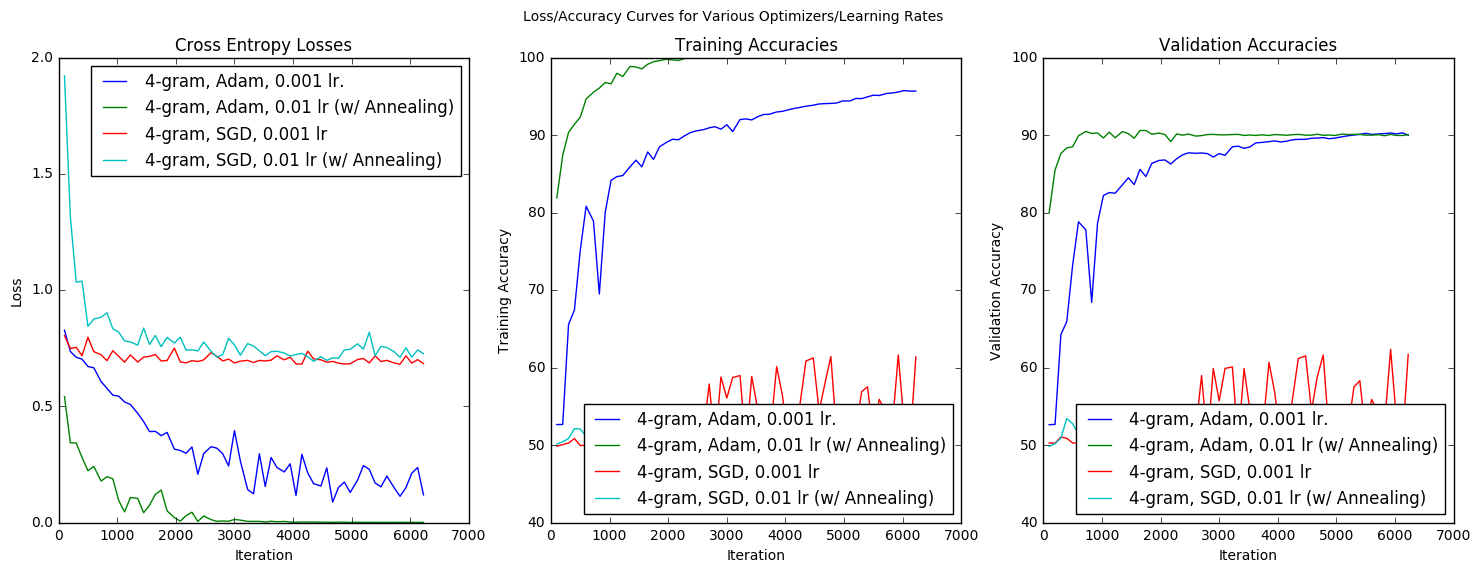

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(losses_17.items())), label="4-gram, Adam, 0.001 lr.")
axs[0].plot(*zip(*sorted(losses_18.items())), label="4-gram, Adam, 0.01 lr (w/ Annealing)")
axs[0].plot(*zip(*sorted(losses_19.items())), label="4-gram, SGD, 0.001 lr")
axs[0].plot(*zip(*sorted(losses_20.items())), label="4-gram, SGD, 0.01 lr (w/ Annealing)")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(training_accs_17.items())), label="4-gram, Adam, 0.001 lr.")
axs[1].plot(*zip(*sorted(training_accs_18.items())), label="4-gram, Adam, 0.01 lr (w/ Annealing)")
axs[1].plot(*zip(*sorted(training_accs_19.items())), label="4-gram, SGD, 0.001 lr")
axs[1].plot(*zip(*sorted(training_accs_20.items())), label="4-gram, SGD, 0.01 lr (w/ Annealing)")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(val_accs_17.items())), label="4-gram, Adam, 0.001 lr.")
axs[2].plot(*zip(*sorted(val_accs_18.items())), label="4-gram, Adam, 0.01 lr (w/ Annealing)")
axs[2].plot(*zip(*sorted(val_accs_19.items())), label="4-gram, SGD, 0.001 lr")
axs[2].plot(*zip(*sorted(val_accs_20.items())), label="4-gram, SGD, 0.01 lr (w/ Annealing)")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy Curves for Various Optimizers/Learning Rates')
plt.show()

In [53]:
print('------------------------------------------------------------------')
print('unprocessed text, 4gram, 30000 vocab, 100 embed_dim, adam, 0.001 lr')
_, _, _, model = create_run_model(pre_train_tokens_4gram, y_train, pre_val_tokens_4gram, y_val, pre_test_tokens_4gram, test_reviews_target, pre_all_train_tokens_4gram, 
                                                    30000, 32, 100, 'adam', 0.001, False)


------------------------------------------------------------------
unprocessed text, 4gram, 30000 vocab, 100 embed_dim, adam, 0.001 lr
Building indices/vocab...
Building datasets/dataloaders...
Building model...
Epoch: [1/10], Step: [625/625], Validation Acc: 76.16
Epoch: [2/10], Step: [625/625], Validation Acc: 77.68
Epoch: [3/10], Step: [625/625], Validation Acc: 86.1
Epoch: [4/10], Step: [625/625], Validation Acc: 87.64
Epoch: [5/10], Step: [625/625], Validation Acc: 88.52
Epoch: [6/10], Step: [625/625], Validation Acc: 89.3
Epoch: [7/10], Step: [625/625], Validation Acc: 89.48
Epoch: [8/10], Step: [625/625], Validation Acc: 90.04
Epoch: [9/10], Step: [625/625], Validation Acc: 90.28
Epoch: [10/10], Step: [625/625], Validation Acc: 90.0
Testing acc: 89.424


In [80]:
#Begin receiving three true and three false results now.
# token2id, id2token = build_vocab(pre_all_train_tokens_4gram, 30000)
val_data_indices = token2index_dataset(pre_val_tokens_4gram, token2id)
val_dataset = MoviesReviewsDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=32,
                                           collate_fn=reviews_collate_func,
                                           shuffle=True)

In [116]:
correct = 0
total = 0
model.eval()
correctly_predicted = []
falsely_predicted = []
for data, lengths, labels in val_loader:
    if len(falsely_predicted) >= 3 and len(correctly_predicted) >= 3:
        break
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    total += labels.size(0)
    correct += predicted.eq(labels.view_as(predicted)).sum().item()
    for i in range(0, len(data_batch)):
        if predicted.eq(labels.view_as(predicted))[i].item() == 1:
            correctly_predicted.append(data_batch[i])
        else:
            falsely_predicted.append(data_batch[i])

In [148]:
correctly_predicted = correctly_predicted[:3]
falsely_predicted = falsely_predicted[:3]

print('CORRECTLY PREDICTED:')
for review in correctly_predicted:
    print(' '.join(map(' '.join, [id2token[i] for i in review.numpy() if i != 1 and i != 0])))
    print('--------------------------------------------------')
    
print('FALSELY PREDICTED:')
for review in falsely_predicted:
    print(' '.join(map(' '.join, [id2token[i] for i in review.numpy() if i != 1 and i != 0])))
    print('--------------------------------------------------')

CORRECTLY PREDICTED:
and when i watch sarah i get the same results i love quirky humor but this woman is so boring annoying and shes also totally lacking in anything whatsoever humorous the way she tries to deliver her lines is just dead on arrival because shes just not funny i watched two segments of her program and was ready for my kid age 19 saw her on comedy central and said she was a dumb chick i thought that was a compliment the one where she says watch my show or ill kill my dog is actually believable i know shes a wan na be she just comes across as a i just dont ever want to see her around my dog and when when i i watch i get get the the same i love but this this woman woman is is so annoying and lacking in way she she tries tries to to deliver is just because shes just not not funny funny i i watched of her and was ready for and said she was was a a dumb i thought thought that that was was a the one one where where she she says is actually i know shes a wan na na be she just c